In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Dark2_7
import xarray as xr
import seaborn as sns
import copy
%matplotlib inline

import os
os.environ['PROJ_LIB'] = '/Users/hujun/.pyenv/versions/anaconda3-5.0.1/share/proj'
from mpl_toolkits.basemap import Basemap,addcyclic,shiftgrid

In [2]:
plt.style.use('junhu')

In [3]:
#read SPEEDY-IER data
#modern
sp1 = xr.open_dataset('/Users/hujun/Dropbox/RCP85/attmB20_1974-2013.nc')
#future
sp2 = xr.open_dataset('/Users/hujun/Dropbox/RCP85/attmB23_2074-2113.nc')

In [4]:
# coordinates of SPEEDY-IER
lat_sp=sp1.lat
lon_sp=sp1.lon
lev_sp=sp1.lev

In [5]:
lev_sp

<xarray.DataArray 'lev' (lev: 8)>
array([925., 850., 700., 500., 300., 200., 100.,  30.])
Coordinates:
  * lev      (lev) float64 925.0 850.0 700.0 500.0 300.0 200.0 100.0 30.0
Attributes:
    long_name:  generic
    units:      level
    axis:       Z

In [5]:
# coordinates of iCAM5
dr='/Users/hujun/Dropbox/model_complexity/CAM5_Modern_RCP85/'

lon0_cam=np.load(dr+'CAM5_lons.npy')
lat0_cam=np.load(dr+'CAM5_lats.npy')
lev_cam=np.load(dr+'CAM5_levs.npy')

lat_cam=lat0_cam[31:161]
lon_cam=lon0_cam

## Water vapor isotopes

In [6]:
# water vapor dD
# SPEEDY-IER
qdo1_sp = (sp1.hdo/sp1.h2o-1)*1000
qdo2_sp = (sp2.hdo/sp2.h2o-1)*1000
qdo_diff_sp = qdo2_sp.mean(dim='time')-qdo1_sp.mean(dim='time')

r1_sp = sp1.hdo/sp1.h2o
r2_sp = sp2.hdo/sp2.h2o

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
# iCAM5
Q=np.load(dr+'CAM_VARS_H216OV_modern.npy')[0:-2,:,31:161,:]
QE=np.load(dr+'CAM_VARS_H216OV_2100.npy')[0:-2,:,31:161,:]

D=np.load(dr+'CAM_VARS_HDOV_modern.npy')[0:-2,:,31:161,:]
DE=np.load(dr+'CAM_VARS_HDOV_2100.npy')[0:-2,:,31:161,:]

# water vapor dD
qdo1_cam=(D/Q-1)*1000
qdo2_cam=(DE/QE-1)*1000

qdo_diff_cam = np.average(qdo2_cam,axis=0)-np.average(qdo1_cam,axis=0)

r1_cam=D/Q
r2_cam=DE/QE

In [8]:
# iCAM5
WE=np.load(dr+'CAM_VARS_OMEGA_2100.npy')[0:-2,:,31:161,:]
WC=np.load(dr+'CAM_VARS_OMEGA_modern.npy')[0:-2,:,31:161,:]

WC_mean = np.average(WC,axis=0)
WE_mean = np.average(WE,axis=0)

In [9]:
# SPEEDY-IER
omega_tropics1_sp=sp1.omega.sel(lat=slice(-10,10)).mean(dim=['time','lat'])
omega_tropics2_sp=sp2.omega.sel(lat=slice(-10,10)).mean(dim=['time','lat'])

In [10]:
#iCAM5
WC_tropics=np.average(WC_mean[:,53:77,:],axis=1)
WE_tropics=np.average(WE_mean[:,53:77,:],axis=1)

In [11]:
# tropical mean dD
# SPEEDY-IER
r1_tropics_sp=r1_sp.sel(lat=slice(-10,10)).mean(dim=['time','lat'])
r2_tropics_sp=r2_sp.sel(lat=slice(-10,10)).mean(dim=['time','lat'])
# iCAM5
r1_tropics_cam=np.average(r1_cam[:,:,53:77,:],axis=(0,2))
r2_tropics_cam=np.average(r2_cam[:,:,53:77,:],axis=(0,2))

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Vertical advection

In [12]:
# SPEEDY-IER
adv1_sp=np.zeros(omega_tropics1_sp.shape)
adv2_sp=np.zeros(omega_tropics2_sp.shape)
for k in range(len(lev_sp)):
    if k==7:
        adv1_sp[k,:]=omega_tropics1_sp[k,:]*(r1_tropics_sp[k,:]-r1_tropics_sp[k-1,:])/(lev_sp[k]-lev_sp[k-1])
        adv2_sp[k,:]=omega_tropics2_sp[k,:]*(r2_tropics_sp[k,:]-r2_tropics_sp[k-1,:])/(lev_sp[k]-lev_sp[k-1])
    else:
        adv1_sp[k,:]=omega_tropics1_sp[k,:]*(r1_tropics_sp[k+1,:]-r1_tropics_sp[k-1,:])/(lev_sp[k+1]-lev_sp[k-1])
        adv2_sp[k,:]=omega_tropics2_sp[k,:]*(r2_tropics_sp[k+1,:]-r2_tropics_sp[k-1,:])/(lev_sp[k+1]-lev_sp[k-1])

In [13]:
# iCAM5
adv1_cam=np.zeros(WC_tropics.shape)
adv2_cam=np.zeros(WC_tropics.shape)
for k in range(len(lev_cam)):
    if k==len(lev_cam)-1:
        adv1_cam[k,:]=WC_tropics[k,:]*(r1_tropics_cam[k,:]-r1_tropics_cam[k-1,:])/(lev_cam[k]-lev_cam[k-1])
        adv2_cam[k,:]=WE_tropics[k,:]*(r2_tropics_cam[k,:]-r2_tropics_cam[k-1,:])/(lev_cam[k]-lev_cam[k-1])
    else:
        adv1_cam[k,:]=WC_tropics[k,:]*(r1_tropics_cam[k+1,:]-r1_tropics_cam[k-1,:])/(lev_cam[k+1]-lev_cam[k-1])
        adv2_cam[k,:]=WE_tropics[k,:]*(r2_tropics_cam[k+1,:]-r2_tropics_cam[k-1,:])/(lev_cam[k+1]-lev_cam[k-1])

In [14]:
def latlonformat(lats,flag):
    '''
    Plot degree symbol and W/E/S/N for longitude/latitude
    lats: list of latitude or longitude
    flag: whether the input is latitude or longitude
        options: 'lat' and 'lon'
    Output:
    A list of lat/lon labels
    '''
    label_list=[]
    if flag=='lat':
        for lat in lats:
            if lat<0:
                label=str(int(-lat))+u'\u00B0S'
            elif lat>0:
                label=str(int(lat))+u'\u00B0N'
            else:
                label=str(int(lat))
            label_list.append(label)
    elif flag=='lon':
        for lat in lats:
            if lat>0 and lat<180:
                label=str(int(lat))+u'\u00B0E'
            elif lat>180 and lat<=360:
                label=str(int(360-lat))+u'\u00B0W'
            elif lat<0:
                label=str(int(-lat))+u'\u00B0W'
            else:
                label=str(int(lat))
            label_list.append(label)
    
    return label_list

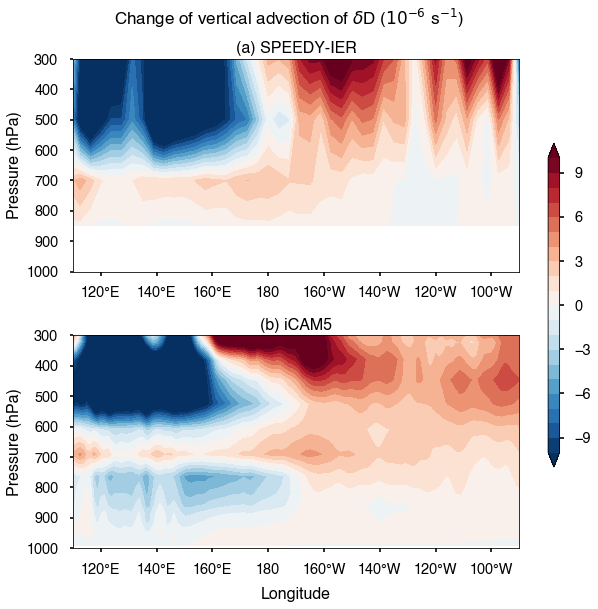

In [16]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
fig, ax = plt.subplots(2,figsize=(8,9))
fig.suptitle(u'Change of vertical advection of $\delta$D (${10}^{-6}~$s$^{-1}$)',fontsize=17,y=0.96)
for i in range(2):
    clevs=np.linspace(-10,10,21)
    if i==0:
        cs=ax[i].contourf(lon_sp,lev_sp,-(adv2_sp-adv1_sp)*1e6,clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(a) SPEEDY-IER',fontsize=16)
    else:
        cs=ax[i].contourf(lon_cam,lev_cam,-(adv2_cam-adv1_cam)*1e6,clevs,cmap=plt.cm.RdBu_r,extend='both')
        ax[i].set_title('(b) iCAM5',fontsize=16)

    ax[i].set_xlim(110,270)
    a=ax[i].get_xticks().tolist()
    ax[i].set_xticklabels(latlonformat(a,'lon'))
    
    ax[i].set_ylim(300,1000)
    ax[i].set_ylabel('Pressure (hPa)')
    if i==1:
        ax[i].set_xlabel('Longitude',labelpad=10)
    ax[i].invert_yaxis()

fig.subplots_adjust(hspace=0.3)
cb_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(cs, cax=cb_ax,orientation='vertical')
#cbar.set_label('(Pa/s)', labelpad=-30, y=1.02, rotation=0)

fig.savefig('adv_vert_diff.pdf',dpi=300,bbox_inches='tight')

## Horizontal advection

In [35]:
# get wind
# SPEEDY-IER
u1_sp = sp1.u.mean(dim='time')
v1_sp = sp1.v.mean(dim='time')
u2_sp = sp2.u.mean(dim='time')
v2_sp = sp2.v.mean(dim='time')

In [37]:
u_diff_sp=u2_sp-u1_sp
v_diff_sp=v2_sp-v1_sp

In [36]:
# iCAM5
UE=np.load(dr+'CAM_VARS_U_2100.npy')[0:-2,:,31:161,:]
UC=np.load(dr+'CAM_VARS_U_modern.npy')[0:-2,:,31:161,:]

VE=np.load(dr+'CAM_VARS_V_2100.npy')[0:-2,:,31:161,:]
VC=np.load(dr+'CAM_VARS_V_modern.npy')[0:-2,:,31:161,:]

UC_mean = np.average(UC,axis=0)
UE_mean = np.average(UE,axis=0)

VC_mean = np.average(VC,axis=0)
VE_mean = np.average(VE,axis=0)

In [38]:
u_diff_cam = UE_mean-UC_mean
v_diff_cam = VE_mean-VC_mean

In [41]:
# water vapor dD
qdo1_sp_mean = qdo1_sp.mean(dim='time')
qdo1_cam_mean = np.average(qdo1_cam,axis=0)

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [63]:
# interpolate dD_dyn to 600hPa for iCAM5
# to avoid the wierd vector plotting problem
import Ngl

P0=np.load(dr+'P0.npy')
PS=np.load(dr+'PS_2100.npy')[0:-2,31:161,:]

hyam=np.load(dr+'hyam.npy')
hyai=np.load(dr+'hyai.npy')
hybm=np.load(dr+'hybm.npy')
hybi=np.load(dr+'hybi.npy')

PS_mean = np.average(PS,axis=0)

P0mb=P0/100
intyp = 1
kxtrp = False

#interpolation
UE_cam_600 = Ngl.vinth2p(UE_mean,hyam,hybm,[600.],PS_mean,intyp,P0mb,1,kxtrp)
UC_cam_600 = Ngl.vinth2p(UC_mean,hyam,hybm,[600.],PS_mean,intyp,P0mb,1,kxtrp)
VE_cam_600 = Ngl.vinth2p(VE_mean,hyam,hybm,[600.],PS_mean,intyp,P0mb,1,kxtrp)
VC_cam_600 = Ngl.vinth2p(VC_mean,hyam,hybm,[600.],PS_mean,intyp,P0mb,1,kxtrp)
qdo1_cam_mean_600 = Ngl.vinth2p(qdo1_cam_mean,hyam,hybm,[600.],PS_mean,intyp,P0mb,1,kxtrp)

In [53]:
# interpolate wind difference to 600hPa for SPEEDY-IER
from scipy import interpolate

f = interpolate.interp1d(lev_sp,u_diff_sp,axis=0)
u_diff_sp_600 = f(600)
f = interpolate.interp1d(lev_sp,v_diff_sp,axis=0)
v_diff_sp_600 = f(600)
f = interpolate.interp1d(lev_sp,qdo1_sp_mean,axis=0)
qdo1_sp_mean_600 = f(600)

In [59]:
f = interpolate.interp1d(lev_sp,u1_sp,axis=0)
u1_sp_600 = f(600)
f = interpolate.interp1d(lev_sp,u2_sp,axis=0)
u2_sp_600 = f(600)
f = interpolate.interp1d(lev_sp,v1_sp,axis=0)
v1_sp_600 = f(600)
f = interpolate.interp1d(lev_sp,v2_sp,axis=0)
v2_sp_600 = f(600)

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


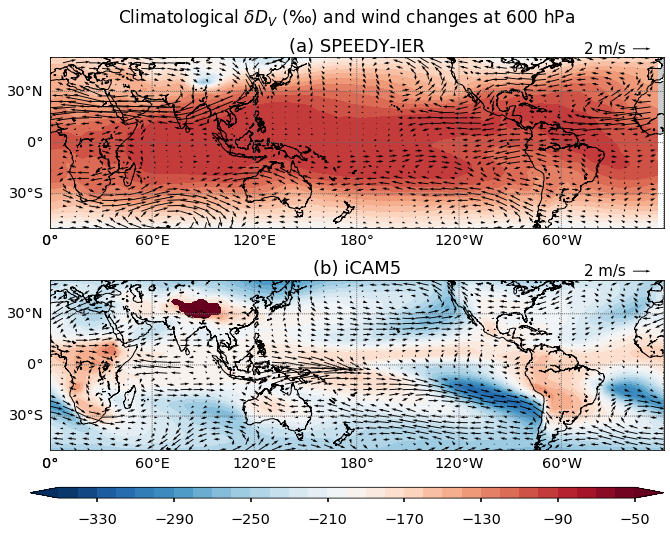

In [64]:
map = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=50,llcrnrlon=0,urcrnrlon=360,lat_ts=20,resolution='l')
fig=plt.figure(figsize=(11,7.5))
fig.suptitle(u'Climatological $\delta{D}_{V}$ (\u2030) and wind changes at 600 hPa ',fontsize=17,y=0.96)

ax1=fig.add_subplot(211)
ax1.set_title('(a) SPEEDY-IER')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_sp.values, lat_sp.values)
x1,y1 = map(lons, lats)
clevs=np.linspace(-350,-50,31)
cs=map.contourf(x1,y1,qdo1_sp_mean_600,clevs,cmap=plt.cm.RdBu_r,extend='both')

uproj,vproj,xu,yu = map.transform_vector(u2_sp_600-u1_sp_600,v2_sp_600-v1_sp_600,lon_sp.values,lat_sp.values,48,32,returnxy=True,masked=True)
# now plot.
Q = map.quiver(xu,yu,uproj,vproj,width=0.0015,scale=70)
qk = plt.quiverkey(Q, 0.95, 1.05, 2, '2 m/s', labelpos='W',fontproperties={'size': '15'})

ax2=fig.add_subplot(212)
ax2.set_title('(b) iCAM5')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_cam, lat_cam)
x1,y1 = map(lons, lats)
cs=map.contourf(x1,y1,qdo1_cam_mean_600[0,:,:],clevs,cmap=plt.cm.RdBu_r,extend='both')

uproj,vproj,xu,yu = map.transform_vector(UE_cam_600[0,:,:]-UC_cam_600[0,:,:],VE_cam_600[0,:,:]-VC_cam_600[0,:,:],lon_cam,lat_cam,48,32,returnxy=True,masked=True)
# now plot.
Q = map.quiver(xu,yu,uproj,vproj,width=0.0015,scale=70)
qk = plt.quiverkey(Q, 0.95, 1.05, 2, '2 m/s', labelpos='W',fontproperties={'size': '15'})

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cs, cax=cb_ax, orientation='horizontal')
#cbar.set_label('(mm/day)', labelpad=-16, x=0.95,y=-0.6, rotation=0)

fig.savefig('dD_clim_wind_diff_600.pdf',dpi=300,bbox_inches='tight')

In [78]:
u1=sp1.u
v1=sp1.v
u2=sp2.u
v2=sp2.v

In [91]:
r=6.4e6
dx_sp=np.empty_like(u1)
for i in range(len(lat_sp)):
    dx_sp[:,:,i,:]=r*np.gradient(lon_sp.values)*np.pi/180*np.cos(lat_sp[i].values/180*np.pi)

# zonal advection
uadv_modern_sp=u1*np.gradient(r1_sp,axis=3)/dx_sp
uadv_future_sp=u2*np.gradient(r2_sp,axis=3)/dx_sp

# meridional advection
dy_sp=np.tile(r*np.gradient(lat_sp)*np.pi/180,(u1.shape[0],u1.shape[1],u1.shape[3],1))
dy_sp=np.swapaxes(dy_sp,3,2)

vadv_modern_sp = v1*np.gradient(r1_sp,axis=2)/dy_sp
vadv_future_sp = v2*np.gradient(r2_sp,axis=2)/dy_sp

In [167]:
adv_diff_sp = uadv_future_sp.values-uadv_modern_sp.values+vadv_future_sp.values-vadv_modern_sp.values
adv_diff_mean_sp=np.average(adv_diff_sp,axis=0)

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [149]:
def hori_adv(r1_sp,r2_sp,u1,u2,v1,v2,lat_sp,lon_sp):
    dx_sp=np.empty_like(u1)
    for i in range(len(lat_sp)):
        dx_sp[:,:,i,:]=r*np.gradient(lon_sp)*np.pi/180*np.cos(lat_sp[i]/180*np.pi)

    # zonal advection
    uadv_modern_sp=u1*np.gradient(r1_sp,axis=3)/dx_sp
    uadv_future_sp=u2*np.gradient(r2_sp,axis=3)/dx_sp

    # meridional advection
    dy_sp=np.tile(r*np.gradient(lat_sp)*np.pi/180,(u1.shape[0],u1.shape[1],u1.shape[3],1))
    dy_sp=np.swapaxes(dy_sp,3,2)

    vadv_modern_sp = v1*np.gradient(r1_sp,axis=2)/dy_sp
    vadv_future_sp = v2*np.gradient(r2_sp,axis=2)/dy_sp
    
    adv_diff_sp = uadv_future_sp-uadv_modern_sp+vadv_future_sp-vadv_modern_sp
    adv_diff_mean_sp=np.average(adv_diff_sp,axis=0)
    
    return adv_diff_mean_sp

In [150]:

adv_diff_mean_cam=hori_adv(r1_cam,r2_cam,UC,UE,VC,VE,lat_cam,lon_cam)

In [153]:
adv_diff_mean_cam_600 = Ngl.vinth2p(adv_diff_mean_cam,hyam,hybm,[600.],PS_mean,intyp,P0mb,1,kxtrp)

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


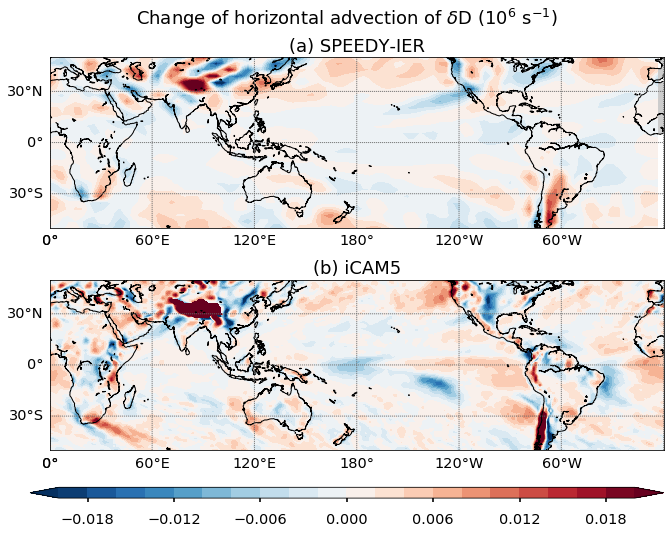

In [168]:
map = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=50,llcrnrlon=0,urcrnrlon=360,lat_ts=20,resolution='l')
fig=plt.figure(figsize=(11,7.5))
fig.suptitle(u'Change of horizontal advection of $\delta$D (${10}^6~$s$^{-1}$)',fontsize=18,y=0.96)

ax1=fig.add_subplot(211)
ax1.set_title('(a) SPEEDY-IER')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_sp.values, lat_sp.values)
x1,y1 = map(lons, lats)
clevs=np.linspace(-0.02,0.02,21)
cs=map.contourf(x1,y1,adv_diff_mean_sp[3,:,:]*86400,clevs,cmap=plt.cm.RdBu_r,extend='both')

ax2=fig.add_subplot(212)
ax2.set_title('(b) iCAM5')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_cam, lat_cam)
x1,y1 = map(lons, lats)
cs=map.contourf(x1,y1,adv_diff_mean_cam_600[0,:,:]*86400,clevs,cmap=plt.cm.RdBu_r,extend='both')
#cbar = map.colorbar(cs,location='bottom',pad=0.35)
#cbar.set_label('(mm/day)', labelpad=-16, x=0.95,y=-0.6, rotation=0)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cs, cax=cb_ax, orientation='horizontal')
#cbar.set_label('(mm/day)', labelpad=-16, x=0.95,y=-0.6, rotation=0)

fig.savefig('Horizontal_advection_diff.pdf',dpi=300,bbox_inches='tight')

/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/Users/hujun/.pyenv/versions/anaconda3-5.0.1/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


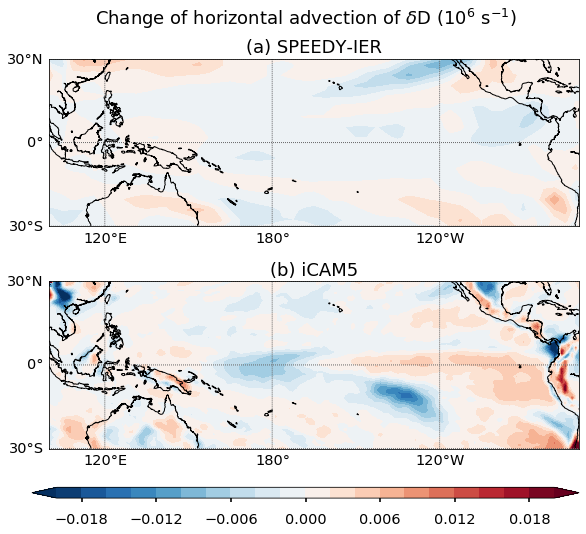

In [171]:
map = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=30,llcrnrlon=100,urcrnrlon=290,lat_ts=20,resolution='l')
fig=plt.figure(figsize=(9.5,7.5))
fig.suptitle(u'Change of horizontal advection of $\delta$D (${10}^6~$s$^{-1}$)',fontsize=18,y=0.96)

ax1=fig.add_subplot(211)
ax1.set_title('(a) SPEEDY-IER')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_sp.values, lat_sp.values)
x1,y1 = map(lons, lats)
clevs=np.linspace(-0.02,0.02,21)
cs=map.contourf(x1,y1,adv_diff_mean_sp[3,:,:]*86400,clevs,cmap=plt.cm.RdBu_r,extend='both')

ax2=fig.add_subplot(212)
ax2.set_title('(b) iCAM5')
map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,1],color='DimGray',fontsize=14.5)
map.drawparallels(np.arange(-60,60,30),labels=[1,0,0,0],color='DimGray',fontsize=14.5)

lons, lats = np.meshgrid(lon_cam, lat_cam)
x1,y1 = map(lons, lats)
cs=map.contourf(x1,y1,adv_diff_mean_cam_600[0,:,:]*86400,clevs,cmap=plt.cm.RdBu_r,extend='both')
#cbar = map.colorbar(cs,location='bottom',pad=0.35)
#cbar.set_label('(mm/day)', labelpad=-16, x=0.95,y=-0.6, rotation=0)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = fig.colorbar(cs, cax=cb_ax, orientation='horizontal')
#cbar.set_label('(mm/day)', labelpad=-16, x=0.95,y=-0.6, rotation=0)

fig.savefig('Horizontal_advection_diff_Pacific.pdf',dpi=300,bbox_inches='tight')